<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tutorial-22:-Temperature-Accelerated-MD-for-Surface-Atom-Diffusion" data-toc-modified-id="Tutorial-22:-Temperature-Accelerated-MD-for-Surface-Atom-Diffusion-22"><span class="toc-item-num">22&nbsp;&nbsp;</span>Tutorial 22: Temperature Accelerated MD for Surface Atom Diffusion</a></span><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-22.1"><span class="toc-item-num">22.1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Load-configuration" data-toc-modified-id="Load-configuration-22.2"><span class="toc-item-num">22.2&nbsp;&nbsp;</span>Load configuration</a></span></li><li><span><a href="#MD-simulation-with-NVT-ensemble-at-high-temperature" data-toc-modified-id="MD-simulation-with-NVT-ensemble-at-high-temperature-22.3"><span class="toc-item-num">22.3&nbsp;&nbsp;</span>MD simulation with NVT ensemble at high temperature</a></span></li></ul></li></ul></div>

# Tutorial 22: Temperature Accelerated MD for Surface Atom Diffusion
Yikai Yin and Wei Cai

**2019-07-06**

## Initialization


**1. This notebook uses the following extensions, please set them up in nbextensions before using this notebook**
* Table of Content (2)

<sub>Instructions for nbextension installation is in [Tutorial 01 1.2.2.2](Tutorial%2001%20-%20Introduction%20to%20MD%2B%2B.ipynb)</sub>

**2. OVITO for visualizing configurations**

<sub>Instructions for OVITO installation in [Tutorial 08](Tutorial%2008%20-%20Introduction%20to%20OVITO.ipynb) </sub>

**3. If you have not set the environment variables, please add the following 4 lines into `~/.bashrc`, and reboot Ubuntu to setup the environment variables**

These environmental variables specifies the MD++ root directory, the MD++ compiling system, and name of the MD++ executable, respectively.

**3. Check if environmental variables are set. Change current working directory into the MD++ root folder**

In [1]:
import os

envvar_test = True
envvars = ['MDPLUS_DIR', 'MDPLUS_EXE', 'MDPLUS_SYS', 'OVITOS_BIN']
for envvar in envvars:
    if envvar not in os.environ.keys():
        print('Environment variable "'+envvar+'" not set')
        envvar_test = False
    else:
        print('Environment variable "'+envvar+'" set to '+os.environ[envvar])

if not envvar_test:
    raise OSError

mdpp_dir = os.environ['MDPLUS_DIR']
os.chdir(mdpp_dir)

Environment variable "MDPLUS_DIR" set to /home/yikai/Codes/MD++.git
Environment variable "MDPLUS_EXE" set to python3
Environment variable "MDPLUS_SYS" set to gpp
Environment variable "OVITOS_BIN" set to /home/yikai/Codes/ovito-2.9.0-x86_64/bin


## Load configuration

We will convert the initial configuration from a different code (TAD 3.46) to MD++ .cn format and then read it into MD++.

**Compile the fs executable**

In [2]:
%%sh
cd $MDPLUS_DIR
make clean; make fs SYS=$MDPLUS_SYS build=R PY=yes

rm -f bin/*_* bin/*.so
cd src; make clean; cd ..
make[1]: Entering directory '/home/yikai/Codes/MD++.git/src'
rm -f display.o organizer.o filecls.o mdparallel.o relax_zxcgr.o general.o scparser.o relax_prplus.o md.o
make[1]: Leaving directory '/home/yikai/Codes/MD++.git/src'
cd Fortran/MEAM-Marian; make clean;
make[1]: Entering directory '/home/yikai/Codes/MD++.git/Fortran/MEAM-Marian'
rm -f disperx disper.o input.o forces.o linvlc.o krameam.o rhomeam.o tred2.o tqli.o meamfunctions.o screen.o dscreen.o dscrfor.o
make[1]: Leaving directory '/home/yikai/Codes/MD++.git/Fortran/MEAM-Marian'
cd Fortran/MEAM-Baskes/meam/linux; make clean;
make[1]: Entering directory '/home/yikai/Codes/MD++.git/Fortran/MEAM-Baskes/meam/linux'
rm -f *.o dyn88
make[1]: Leaving directory '/home/yikai/Codes/MD++.git/Fortran/MEAM-Baskes/meam/linux'
cd Fortran/MEAM-Lenosky; make clean;
make[1]: Entering directory '/home/yikai/Codes/MD++.git/Fortran/MEAM-Lenosky'
rm -f test *.o
make[1]: Leaving directory '/home/yika

**Visualize the initial configuration**

Run script [ta_001_int-TAMD.mdpp.py](http://localhost:8888/edit/scripts/ME346B/ta_001_int-TAMD.mdpp.py) with status = 0.  This is just to see that MD++ can convert and load the structure correctly. You will need to rotate the display to see the surface atom (e.g. press the UP button or drag mouse). This initial relaxed configuration is referred to as $\textbf{State A}$.

In [3]:
%%sh
$MDPLUS_EXE scripts/ME346C_solution/ta_001_int-TAMD.mdpp.py 0

MD++ root directory: /home/yikai/Codes/MD++.git
status = 0
T_high = 1500.000000
T_low = 300.000000
nstates = 1
njumps = 1
randseed = 12345
status == 0: NVE MD simulations
NP = 513
box_size = [26.4464, 26.4464, 100.0]
Python is going to sleep for 10 seconds.


[I] MDFrame::initvars()
[I] MDFrame::initparser()
[I] EXEC   setoverwrite
[I] ASSIGN dirname = runs/ta-001-int
[W] directory runs/ta-001-int already exists


## MD simulation with NVT ensemble at high temperature

In this program, we perodically increase the temperature to 2200 K followed by a relaxation to 0 K in order to find neighboring states of a metastable state A at high temperature. See Tutorials 20&21 for details of Temperature Accelerated Dynamics (TAD) algorithm. 

Among all the neighboring states of the initial state (A), the state with the highest predicted transition rate at low temperature is treated as the next state that the particle jump into. This new state is refered as the new State A. 

**Run the [ta_001_int-TAMD.mdpp.py](http://localhost:8888/edit/scripts/ME346B/ta_001_int-TAMD.mdpp.py) script with status = 1**

Notice that in the command line parameters after status is T_high (high temperature, default 2000), T_low (low temperature, default 300), nstates (maximum number of states to search, default 1), njumps (number of jumps to predict at low temperature, default 1) and randseed (seed for random number generator, default 12345). The random number generator is used when initializing velocities. Other parameters can be adjusted in the script.

In [104]:
# Set environment variable T to be the high temperature of all subsequent simulations
import numpy as np
os.environ['T_high'] = '2000'  # in K
os.environ['T_low'] = '1000'   # in K
os.environ['nstates'] = '2'    # max 4 neighboring states of one jump difference
os.environ['njumps'] = '100'     # specify how many jumps to predict at low temperature

random = np.random.randint(1,100000)    # random number
os.environ['RANDOM'] = str(random)

In [105]:
%%sh
cd $MDPLUS_DIR
$MDPLUS_EXE scripts/ME346C_solution/ta_001_int-TAMD.mdpp.py 1 $T_high $T_low $nstates $njumps $RANDOM 
cp runs/ta-001-int/prop.out runs/ta-001-int/prop1.out

MD++ root directory: /home/yikai/Codes/MD++.git
status = 1
T_high = 2000.000000
T_low = 1000.000000
nstates = 2
njumps = 100
randseed = 23582
Predict jump 1
Search for state 1
  iter 1/100 t_high 2/inf: searching states
  iter 1/100 t_high 2/inf: find a different state 
Search for state 2
  iter 1/100 t_high 4/389.07: searching states
  iter 1/100 t_high 4/389.07: find a different state 
  iter 2/100 t_high 6/389.07: find a different state 
  iter 3/100 t_high 8/389.07: searching states
  iter 3/100 t_high 8/389.07: find a different state 
  iter 4/100 t_high 10/389.07: find a different state 
  iter 5/100 t_high 12/389.07: searching states
  iter 5/100 t_high 12/389.07: find a different state 
  iter 6/100 t_high 14/389.07: find a different state 
  iter 7/100 t_high 16/389.07: searching states
  iter 7/100 t_high 16/389.07: find a different state 
  iter 8/100 t_high 18/389.07: find a different state 
  iter 9/100 t_high 20/389.07: searching states
  iter 9/100 t_high 20/389.07: find

[I] MDFrame::initvars()
[I] MDFrame::initparser()
[I] EXEC   setoverwrite
[I] ASSIGN dirname = runs/ta-001-int
[W] directory runs/ta-001-int already exists


We have stored the data information to a dictionary file ("TAD_data_all_jumps.pkl") in the runs/ta-001-int directory. Run the following command to load the data.

In [106]:
import pickle

runsdir = os.path.join(mdpp_dir, 'runs/ta-001-int')

filename = os.path.join(runsdir, "TAD_data_all_jumps.pkl")

infile = open(filename,'rb')
data_all_jumps = pickle.load(infile)
infile.close()

data_all_jumps

{'1_jump': {'T_high': 2000.0,
  'T_low': 1000.0,
  'Epath_list': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
           0.00000000e+00,  0.00000000e+00],
         [-1.36424205e-12,  5.60409921e-03,  3.17589321e-02,
           8.68833974e-02,  1.73145979

Run the following cells to plot the energy barrier and MEP between state A and each of its neighboring state. The Arrhenius plot for mapping high-temperature transition rates to low-temperature transition rates is shown at the end. 

In [11]:
#--------------------------------------------
# Plot the potential metastate states and MEP

# Input:
# Epath_list         # Store the position of all neighboring states

def plot_MEP(Epath_list):
    color_list = ['red','blue','green','purple','yellow','magenta','cyan','gray']
    state_list = ['A','B','C','D','E','F','G']

    fig, axs = plt.subplots(1, 1,figsize=(5,4))
    for i in range(len(Epath_list)):
        if i > 0:
            axs.plot(Epath_list[i], '.-', linewidth=1, antialiased=True, color=color_list[i])

    axs.set_xlabel('chain number')
    axs.set_ylabel('E (eV)')
    axs.set_title('Energy profile along MEP')
                        

In [107]:
#--------------------------------------------                        
# Schematic illustration of the TAD in Arrhenius Plot 
# Mapping the transition rates to low temperature

# Input:
# t_hi_list      # Store the time consumed to find each state at high temperature
# t_lo_list      # Store the time consumed to find each state at low temperature
# Eb_list        # Store the energy barriers between state A and each neighbor state
# T_high         # your high temperature
# T_low          # your high temperature

def plot_Arrhenius(t_hi_list, t_lo_list, Eb_list, T_high, T_low):
    
    color_list = ['red','blue','green','purple','yellow','magenta','cyan','gray']
    
    #t_hi_list = t_list[1:]
    #t_lo_list = t_hi_list * np.exp(Eb_list[1:]/kB* (1/T_low - 1/T_high))

    fig, axs = plt.subplots(1, 1, figsize=(9, 6))
    for i in range(1,len(t_hi_list)):
        axs.plot(np.divide(1,[T_high, T_low]), np.divide(1, [t_hi_list[i], t_lo_list[i]]),'*-',color=color_list[i])

    axs.plot(np.divide(1,[T_high, T_high]), [1e-30, 1],'--',color='red')
    axs.plot(np.divide(1,[T_low, T_low]), [1e-30, 1],'--',color='black')
    axs.set_xlabel('1/T (1/K)')
    axs.set_ylabel('Transition rate (1/ps)');
    axs.set_title('Arrhenius plot')
    axs.set_yscale('log')
    axs.set_xlim((0.0004, 1/T_low + 0.0001))
    axs.set_ylim((1e-10, 1))

    axs.text(1/T_high-0.00007, 1e-3, '$1/T_{high}$', fontsize=12,color='red')
    axs.text(1/T_low+0.00002, 1e-5, '$1/T_{low}$', fontsize=12,color='black')

    plt.show()

<IPython.core.display.Javascript object>


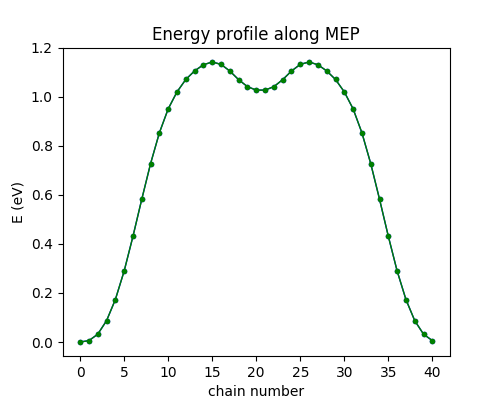

<IPython.core.display.Javascript object>


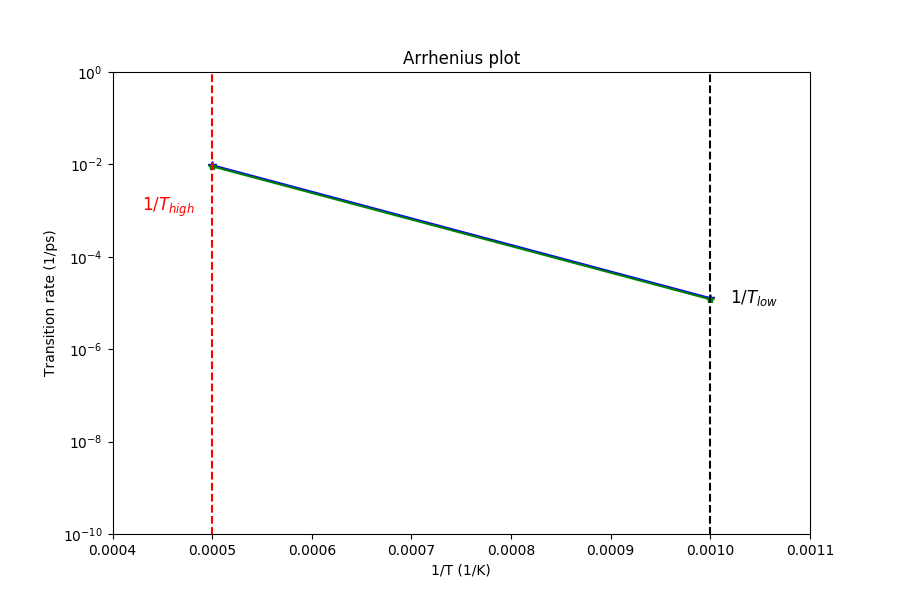

In [143]:
%matplotlib notebook
import matplotlib.pyplot as plt

# Specify the jump number to plot
jump_num_plot = 3 # 1, 2, ... njumps

data_single_jump = data_all_jumps[str(jump_num_plot)+'_jump']

# Plot the potential metastate states and MEP
plot_MEP(data_single_jump['Epath_list'])

# Map to low temperature in an Arrhenius plot
plot_Arrhenius(data_single_jump['t_hi_list'], data_single_jump['t_lo_list'], data_single_jump['Eb_list'],
               data_single_jump['T_high'], data_single_jump['T_low'])  

Run the following lines to visualize the surface adatom (blue sphere) given an state of a jump specified above.

<IPython.core.display.Javascript object>


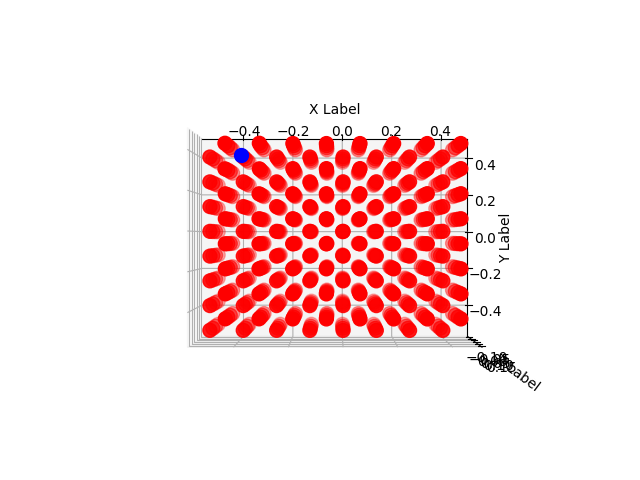

In [109]:
from mpl_toolkits.mplot3d import Axes3D

# Choose a state (configuration) of the jump specified above

state_vis = 2  # 0 (State A), 1, 2 ... the number of states you get

config = data_single_jump['coord_state'+str(state_vis)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf_index = np.argmax(config[:,2]) # pick surface atom
ax.scatter(config[surf_index,0], config[surf_index,1], config[surf_index,2], c='b', marker='o',s=100)
ax.scatter(np.delete(config[:,0],surf_index), np.delete(config[:,1],surf_index), np.delete(config[:,2],surf_index), c='r', marker='o',s=100)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(elev=90, azim=-90)
plt.show()

Run the following lines to visualize the migration pathway for an adatom (blue sphere) on the (001) surface of Ta as revealed from our TAD simulation. 

<IPython.core.display.Javascript object>


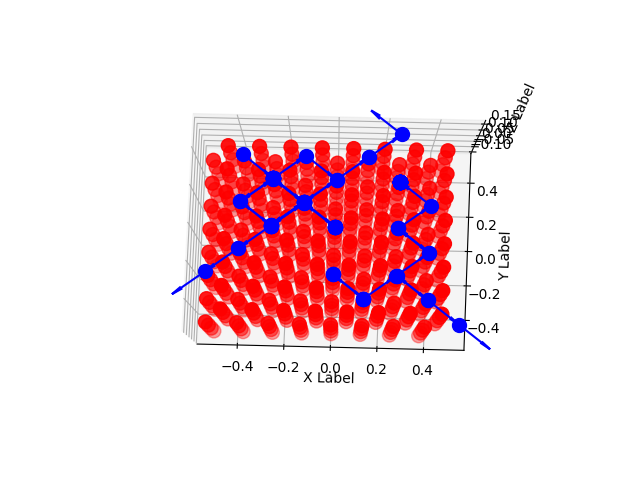

In [135]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  

# plot the initial state
data_single_jump = data_all_jumps['1_jump']
config =data_single_jump['coord_state0']

surf_index = np.argmax(config[:,2]) # pick surface atom
ax.scatter(np.delete(config[:,0],surf_index), np.delete(config[:,1],surf_index), np.delete(config[:,2],surf_index), c='r', marker='o',s=100)
ax.scatter(config[surf_index,0], config[surf_index,1], config[surf_index,2], c='b', marker='o',s=100)

# store the starting point for the arrow
arrow_xA, arrow_yA, arrow_zA =  config[surf_index,0], config[surf_index,1], config[surf_index,2]
arrow_x0, arrow_y0, arrow_z0 =  config[surf_index,0], config[surf_index,1], config[surf_index,2]
dist_low = [0]
disp_low_A = [0]
t_low = [0]

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.view_init(elev=90, azim=-90)

# plot the locations of the surface atoms 

num_jump_set = int(os.environ['njumps'])
                   
for i_jump in range(num_jump_set):
    
    data_single_jump = data_all_jumps[str(i_jump+1)+'_jump']
    
    # index of the state jump into (with lowest time at low T)
    if np.size(data_single_jump['t_lo_list'])==1:  # sometimes no jump happenes given the set up
        ind_t_lo_min = 0
    else:
        ind_t_lo_min = np.argmin(data_single_jump['t_lo_list'][1:])+1  

    config =data_single_jump['coord_state'+str(ind_t_lo_min)]

    surf_index = np.argmax(config[:,2]) # pick surface atom
    ax.scatter(config[surf_index,0], config[surf_index,1], config[surf_index,2], c='b', marker='o',s=100)

    arrow_x, arrow_y, arrow_z =  config[surf_index,0], config[surf_index,1], config[surf_index,2]
    arrow_dx, arrow_dy, arrow_dz =  arrow_x - arrow_x0, arrow_y - arrow_y0, arrow_z - arrow_z0
    
    # displacement with respect to the initial location of State A
    arrow_dx_A, arrow_dy_A, arrow_dz_A =  arrow_x - arrow_xA, arrow_y - arrow_yA, arrow_z - arrow_zA
    
    # Consider PBC when calculating displacement
    h = data_single_jump['h']
    
    dsij = [arrow_dx, arrow_dy, arrow_dz]
    dsij = dsij - np.round(dsij)
    drij = np.dot(h, dsij.T).T
    
    dsij_A = [arrow_dx_A, arrow_dy_A, arrow_dz_A]
    dsij_A = dsij_A - np.round(dsij_A)
    drij_A = np.dot(h, dsij_A.T).T
    
    if np.size(data_single_jump['t_lo_list'])==1: # sometimes no jump happenes given the set up
        dist_low.append(dist_low[-1] + 0)
        disp_low_A.append(disp_low_A[-1] + 0)
    else:
        dist_low.append(dist_low[-1] + np.linalg.norm(drij))
        disp_low_A.append(np.linalg.norm(drij_A))

    
    t_low.append(t_low[-1] + data_single_jump['t_lo_list'][ind_t_lo_min])
    
    ax.quiver(arrow_x0, arrow_y0, arrow_z0, dsij[0], dsij[1], dsij[2], color='b')
                
    arrow_x0, arrow_y0, arrow_z0 = arrow_x, arrow_y, arrow_z
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.view_init(elev=90, azim=-90)


We can also plot the displacements (with respect to State A) and the total jump distance as a function of time at low temperature.

<IPython.core.display.Javascript object>


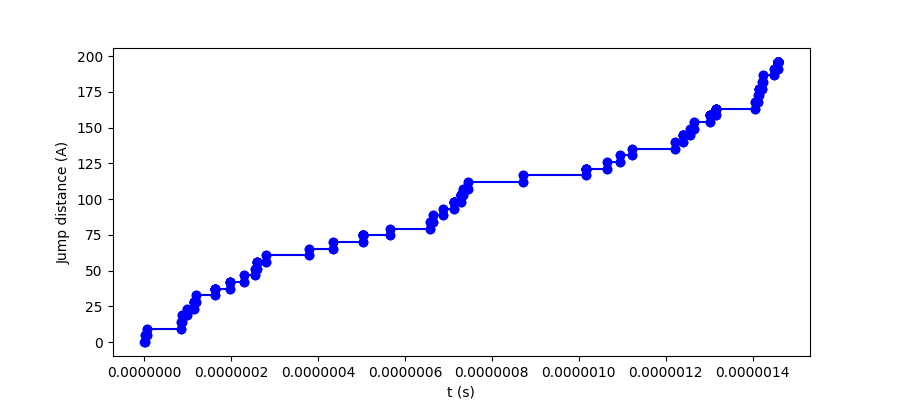

In [136]:
fig, ax = plt.subplots(1, 1,figsize=(9,4))
for i in range(num_jump_set):
    ax.plot(np.array([t_low[i], t_low[i+1]])*1e-12, np.array([dist_low[i], dist_low[i]]), 'o-',color='b')
    ax.plot(np.array([t_low[i+1], t_low[i+1]])*1e-12, np.array([dist_low[i], dist_low[i+1]]), 'o-',color='b')
ax.set_xlabel('t (s)')
ax.set_ylabel('Jump distance (A)');

<IPython.core.display.Javascript object>


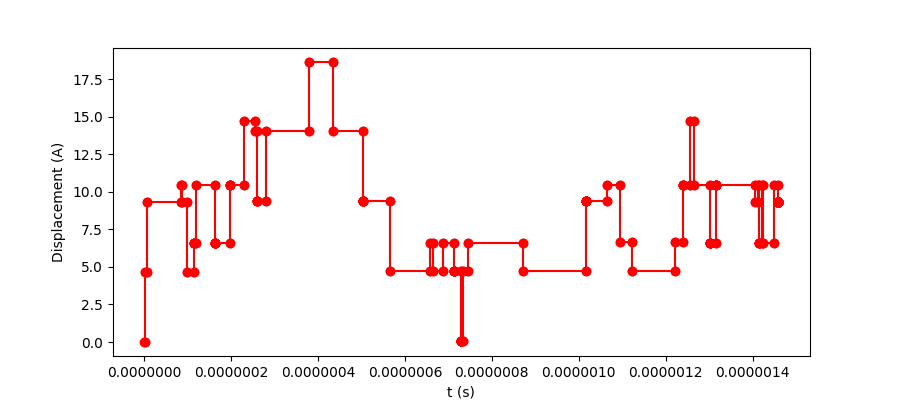

In [137]:
fig, ax = plt.subplots(1, 1,figsize=(9,4))
for i in range(num_jump_set):
    ax.plot(np.array([t_low[i], t_low[i+1]])*1e-12, np.array([disp_low_A[i], disp_low_A[i]]), 'o-',color='r')
    ax.plot(np.array([t_low[i+1], t_low[i+1]])*1e-12, np.array([disp_low_A[i], disp_low_A[i+1]]), 'o-',color='r')
ax.set_xlabel('t (s)')
ax.set_ylabel('Displacement (A)');